#  <b>Classifying Plant Images with a Convolutional Neural Network

### **Context**

Artifical intelligence is changing the way we think of problems. AI is employed across many fields, performing tasks once thought only doable by humans. We now have programs that recognize faces, translate languages, and drive cars. Some advocates even claim *any* activity faciliated by human vision will one day be performed by a machine.

Agriculture is no exception. To successfully grow and harvest crops on a large scale requires vast resources. Beginning in the 1920s, airplanes were used to spray pesticides over crops in order to protect them from insects, fungi, and weeds. More recently, countries have begun banning the aerial application of pesticides due to environmental and public health risks. [[1]](https://eur-lex.europa.eu/legal-content/EN/ALL/?uri=CELEX%3A32009L0128) A safer solution might entail the manual application of pesticides only in problem areas. However, this would likely be a slow process requiring many workers' time and discretion. When we're dealing with thousands of acres of farmland, using human labor for this purpose is unrealistic. That's where we come in. What if we could use AI to locate weeds and neutralize them individually rather than having to spray pesticides over the entire crop? This would not only prevent "spray drift" (where harmful chemicals end up in unintended locations), but would also save money on wasted product. To that end, we can use a convolutional neural network to identify plant species. Once the plants are identified, the proper action (e.g. spray or not spray) can be carried out.

### **Objective**

The aim of this project is to **build a convolutional neural network to classify images of plant seedlings into their respective categories.**


### **Data Description**
The Aarhus University Signal Processing group released a dataset containing nearly 5,000 images of plants belonging to 12 different species.

- The data file names are:
    - images.npy
    - Label.csv
- The images have been converted into numpy arrays to allow for easy model buildling. The .csv file specifies the plant species for each image. 


### **Table of Contents**
1. [Data Overview](#data_overview)
2. [Exploratory Data Analysis](#eda)
3. [Data Preparation](#data_prep)
4. [Model 1: Base Model](#model_1)
5. [Model 1: Data Augmentation](#model_1_aug)
6. [Model 2: Adding Convolutional Layers](#model_2)
7. [Model 3: Adding Batch Normalization](#model_3)
8. [Model 4: Adding Even More Convolutional Layers](#model_4)
9. [Model 5: VGG16](#model_5)
10. [Final Model Comparison](#model_comp)
11. [Conclusion](#conclusion)


### Importing necessary libraries

In [ ]:
# For creating data paths
import os

# To make random selections
import random

# For working with the data
import numpy as np
import pandas as pd

# For creating visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For building the CNNs
import tensorflow as tf
import cv2
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout  
from tensorflow.keras.optimizers import Adam

# For splitting data and measuring model performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Career/AI Course/Projects/Plant Seedling Classification

/content/drive/MyDrive/Career/AI Course/Projects/Plant Seedling Classification


### Read the dataset

In [ ]:
images = np.load('images.npy')
labels = pd.read_csv('Labels.csv')

In [ ]:
len(images)

4750

- There are 4,750 images in the dataset.

In [ ]:
labels.sample(10)

,Label
3588,Sugar beet
2033,Common Chickweed
4077,Black-grass
2176,Charlock
3747,Maize
1747,Common Chickweed
4650,Loose Silky-bent
2305,Charlock
4405,Loose Silky-bent
2711,Scentless Mayweed


- The labels denote the plant species, as seen here.

## Data Overview <a name='data_overview'></a>

#### Checking the shape of the dataset

In [ ]:
images.shape

(4750, 128, 128, 3)

- We have 4,750 images that are each 128 by 128 pixels with 3 channels (RGB).

In [ ]:
labels.shape

(4750, 1)

As expected, there are 4,750 labels.

#### Converting the BGR images to RGB images

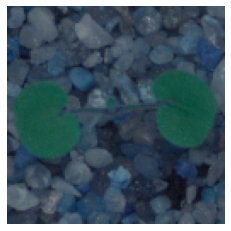

In [ ]:
plt.imshow(images[0])
plt.axis('off')
plt.show()

- Our method of importing the images assumes they are in BGR. They are actually in RGB, and this discrepancy gives the images a strange tint (seen in the photo above). 
- To fix this, we will reorder the channels to reflect the image's true colors.

In [ ]:
# reordering the color channels
images_rgb = images[...,::-1].copy()

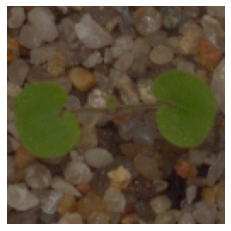

In [ ]:
plt.imshow(images_rgb[0])
plt.axis('off')
plt.show()

- Now the image looks normal.

## Exploratory Data Analysis <a name='eda'></a>

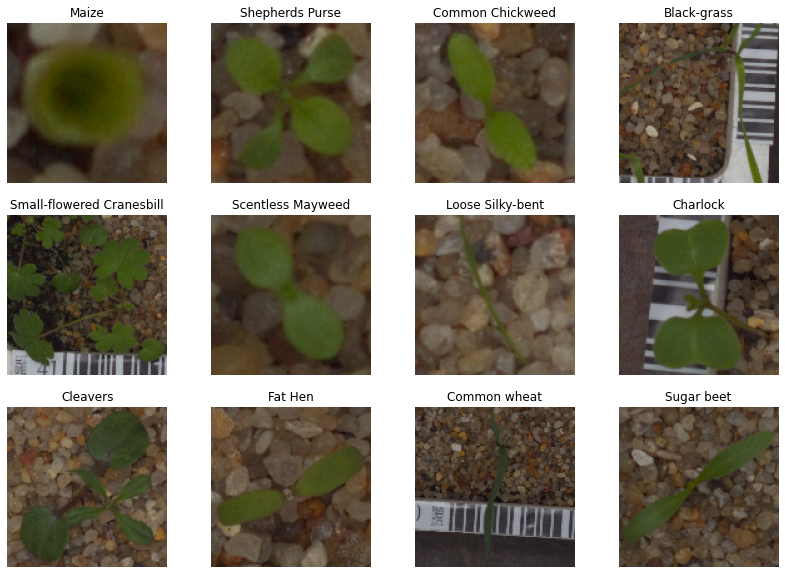

In [ ]:
# plotting a random assortment of each plant species
counter = 0
plotted = []
indexes = []
plt.figure(figsize = (14,10))

while counter < 12:
  index = np.random.randint(0, len(labels))
  label = labels.Label.iloc[index]
  if label not in plotted:
    plt.subplot(3, 4, counter + 1)
    plt.imshow(images_rgb[index])
    plt.title(label)
    plt.axis('off')
    plotted.append(label)
    indexes.append(index)
    counter += 1
  else:
    pass

plt.show()

- The plants are all seedlings, which makes some species difficult to differentiate.
- The Common wheat, Loose Silky-bent, and Black-grass species all have long thin leaves.
- Scentless Mayweed and Common Chickweed both have ovoid leaves extending in opposite directions. Fat Hen also takes this shape.
- These similarities in appearance may lead the model to misclassify similar looking plants.

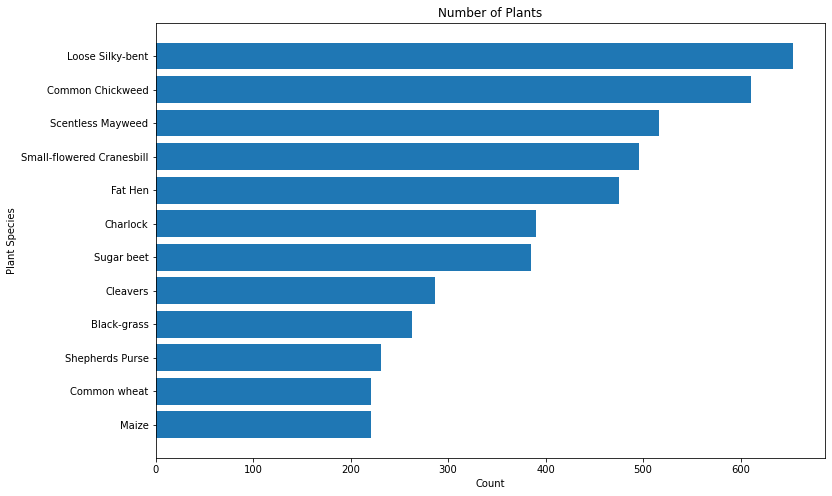

In [ ]:
# getting the value counts of each label
label_breakdown = labels.Label.value_counts()

# plotting the values
plt.figure(figsize=(12,8))
plt.title('Number of Plants')
plt.xlabel('Count')
plt.ylabel('Plant Species')
plt.barh(y=label_breakdown.index, width=label_breakdown.values)
plt.gca().invert_yaxis()
plt.show()

- The plant classes are quite imbalanced.
- There are around three times as many images of Loose Silky-bent plants as Maize plants.
- More images means more information for the model (and hopefully better performance). As a result, this dataset may train a model to better recognize the more common Loose Silky-bent and Common Chickweed images compared to the rarer Shepherds Purse, Common wheat, and Maize species.
- If this proves to be a problem down the line, we can balance the dataset to equalize the count of each species.

## Data Preparation <a name='data_prep'></a>

#### Splitting the data

In [ ]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(images_rgb, labels, test_size = 0.1, random_state = 1, stratify = labels)

In [ ]:
# getting the shape of each dataset
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (4275, 128, 128, 3)
X_test shape: (475, 128, 128, 3)
y_train shape: (4275, 1)
y_test shape: (475, 1)


#### Encoding the target labels

In [ ]:
# encoding the label values

from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()

y_train_enc = binarizer.fit_transform(y_train)
y_test_enc = binarizer.transform(y_test)

In [ ]:
print(f'y_train_enc shape: {y_train_enc.shape}')
print(f'y_test_enc shape: {y_test_enc.shape}')

y_train_enc shape: (4275, 12)
y_test_enc shape: (475, 12)


- The number of rows stayed the same, but now there are 12 columns instead of 1.

In [ ]:
y_train_enc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

- As we can see, each label has been converted to an array of 1s and 0s.
- If the label matches a particular plant species in the array, that index location takes a value of 1.

#### Data Normalization (Scaling)

In [ ]:
# normalizing the train and test set
X_train = X_train / 255.0
X_test = X_test / 255.0

## Model 1 <a name='model_1'></a>

For the first model, we'll train a simple convolutional neural network with 3 convolution layers. We will then identify areas for improvement.

#### Clearing the backend session and initializing the random seed values

In [ ]:
# clearing the backend session
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# initializing random seed values
import random
np.random.seed(1)
random.seed(1) 
tf.random.set_seed(1)

### Model Building (CNN)

In [ ]:
# building a simple CNN model with 3 convolution layers, each with a max pooling layer, followed by 2 fully connected layers

# initializing model
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu', input_shape = (128,128,3)))
model.add(MaxPooling2D((2,2), padding = 'same'))

# 2nd convolution layer
model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D((2,2), padding = 'same'))

# 3rd convolution layer
model.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D((2,2), padding = 'same'))

# flattening output
model.add(Flatten())

# 2 fully connected layers
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))

# output layer
model.add(Dense(12, activation = 'softmax'))

In [ ]:
# compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#### Summary of the model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

- There are 156,716 total parameters in the model.

#### Fitting the model on the train data

In [ ]:
# fitting the model to the data
history = model.fit(X_train, y_train_enc, batch_size = 32, epochs = 36, validation_split = 0.1)

Epoch 1/36
121/121 [==============================] - 12s 25ms/step - loss: 2.4372 - accuracy: 0.1349 - val_loss: 2.3814 - val_accuracy: 0.1612
Epoch 2/36
121/121 [==============================] - 3s 21ms/step - loss: 2.2193 - accuracy: 0.2121 - val_loss: 1.9341 - val_accuracy: 0.3131
Epoch 3/36
121/121 [==============================] - 3s 21ms/step - loss: 1.6508 - accuracy: 0.4185 - val_loss: 1.4763 - val_accuracy: 0.5117
Epoch 4/36
121/121 [==============================] - 3s 21ms/step - loss: 1.3251 - accuracy: 0.5399 - val_loss: 1.1752 - val_accuracy: 0.5958
Epoch 5/36
121/121 [==============================] - 3s 21ms/step - loss: 1.1144 - accuracy: 0.6153 - val_loss: 1.1353 - val_accuracy: 0.6238
Epoch 6/36
121/121 [==============================] - 3s 21ms/step - loss: 0.9715 - accuracy: 0.6714 - val_loss: 1.0314 - val_accuracy: 0.6729
Epoch 7/36
121/121 [==============================] - 2s 21ms/step - loss: 0.8476 - accuracy: 0.7234 - val_loss: 0.9848 - val_accuracy: 0.691

#### Model Evaluation

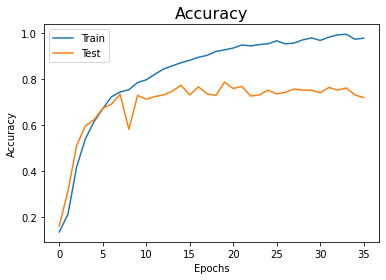

In [ ]:
plt.title('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

- While our training accuracy continued to increase through all epochs, the testing accuracy plateaued midway.
- The training accuracy is good, but the model overfit the training data.

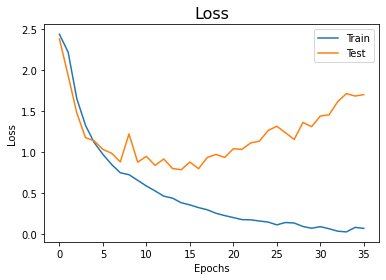

In [ ]:
plt.title('Loss', fontsize=16)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

- The overfitting problem is underscored by these loss curves.
- The testing loss curve decreased until halfway, where it switched directions and increased until the end.

**Observations:** 

#### Evaluating the model on test data

In [ ]:
model.evaluate(X_test, y_test_enc)

15/15 [==============================] - 0s 20ms/step - loss: 2.4567 - accuracy: 0.6674


[2.4567179679870605, 0.6673684120178223]

- The model accurately classified 66.7% of the testing data.

#### Plot the Confusion Matrix




In [ ]:
# calculating predictions
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 8ms/step


In [ ]:
# retrieving original labels from the LabelBinarizer
y_test_labels = binarizer.inverse_transform(y_test_enc)
y_pred_labels = binarizer.inverse_transform(y_pred)

# collecting every species name to define axis labels
labels_alpha = labels.Label.unique()
labels_alpha = list(np.sort(labels_alpha))

# creating a confusion matrix function
def make_confusion_matrix(y_test_labels, y_pred_labels, labels=labels_alpha):  
  cf_matrix = confusion_matrix(y_test_labels, y_pred_labels) # calculating matrix
  plt.figure(figsize=(14,12)) # plotting matrix
  sns.heatmap(cf_matrix, annot=True, cbar=False, fmt='g', cmap='viridis')
  plt.xticks(labels=labels_alpha, ticks=(np.arange(12)+.5), rotation=90)
  plt.yticks(labels=labels_alpha, ticks=(np.arange(12)+.5), rotation=0)
  plt.xlabel('Predicted Label')
  plt.ylabel('Actual Label')
  plt.show()

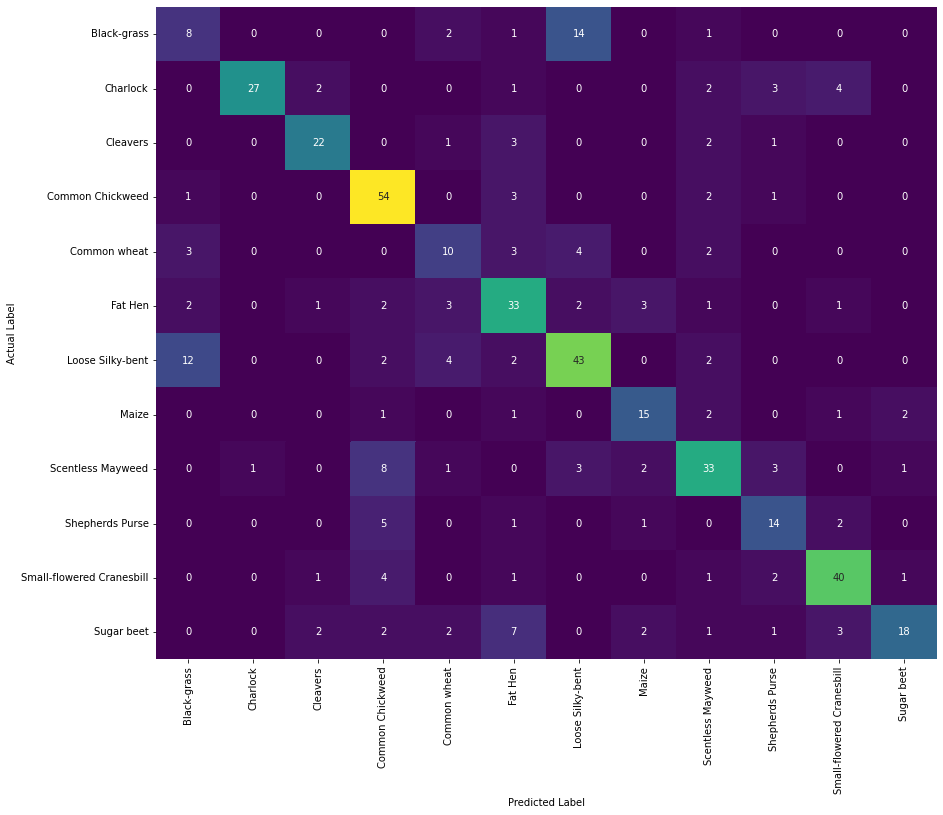

In [ ]:
make_confusion_matrix(y_test_labels, y_pred_labels, labels=labels_alpha)

- While the model's predictions were generally accurate, there were problem areas.
- Loose Silky-bent, Common wheat, and Black-grass were often mischaracterized as each other.
  - We identified this as a potential problem during EDA. The 3 species are remarkably similar in appearance.
  - After some research, I discovered that **Loose Silky-bent and Black-grass are both species of weeds**. If the purpose is to identify weed seedlings in order to neutralize them with pesticides, then this particular misclassification isn't much of a problem. Both species will need to be treated with weed-killer.

#### Plot Classification Report





In [ ]:
print(classification_report(y_test_labels, y_pred_labels))

                           precision    recall  f1-score   support

              Black-grass       0.31      0.31      0.31        26
                 Charlock       0.96      0.69      0.81        39
                 Cleavers       0.79      0.76      0.77        29
         Common Chickweed       0.69      0.89      0.78        61
             Common wheat       0.43      0.45      0.44        22
                  Fat Hen       0.59      0.69      0.63        48
         Loose Silky-bent       0.65      0.66      0.66        65
                    Maize       0.65      0.68      0.67        22
        Scentless Mayweed       0.67      0.63      0.65        52
          Shepherds Purse       0.56      0.61      0.58        23
Small-flowered Cranesbill       0.78      0.80      0.79        50
               Sugar beet       0.82      0.47      0.60        38

                 accuracy                           0.67       475
                macro avg       0.66      0.64      0.64    

- Black-grass and Common wheat recall scores are by far the lowest.
- Small-flowered Cranesbill and Cleavers were the highest across all metrics.
- The model also detected almost all Common Chickweed plants (highest recall).
- Let's see if we can improve our model's performance with data augmentation.

# **Improving the Base Model using Data Augmentation and Regularization** <a name='model_1_aug'></a>




While training these models, I continuously dealt with inconsistency in model performance. I would train two models with the exact same architecture, one on the regular data and the other on the augmented data, and the results would vary. Often the model that initially performed better would then perform worse after restarting the runtime and retraining. I understand that this is due to the stochastic nature of neural networks: the weights are randomly initialized, resulting in different training results every time.

In order to combat this problem, I created a function that trains 8 convolutional neural networks and saves the best one based its accuracy score. By iterating the training process, hopefully we can solve this performance inconsistency problem.

Below, I will train many CNNs with the same architecture -- the first round will be with the original data and the second with the augmented data. Then we can compare accuracy scores to get an idea of which method is better.

### **Data Augmentation**

In [ ]:
# initializing the ImageDataGenerator
train_datagen = ImageDataGenerator(horizontal_flip=True, # we already scaled the data, so we won't do that here
                                   vertical_flip=True,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   rotation_range=20,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   validation_split=0.1)

# augmenting the training data
train_generator = train_datagen.flow(X_train, y_train_enc, subset='training')

# because we are using the ImageDataGenerator, we will have to create our own validation set for model training
val_generator = train_datagen.flow(X_train, y_train_enc, subset='validation')

- Because we already scaled the training and testing sets, we can skip this step here.

In [ ]:
# defining the model repeater function
def model_repeater(X_train, y_train=None, validation_split=0, validation_data=None):
    results = pd.DataFrame(columns=['cnn_model_n', 'accuracy']) # dataframe to save accuracy scores
    cnn_model_n = 1 # defining a variable to track our progress
    best_accuracy = 0
    best_model = 0
    best_model_history = 0
    while cnn_model_n < 9: # training 8 models
      backend.clear_session()
      # this model has the exact same architecture as our first model
      cnn_model = Sequential()
      cnn_model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu', input_shape = (128,128,3)))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Flatten())
      cnn_model.add(Dense(32, activation = 'relu'))
      cnn_model.add(Dense(16, activation = 'relu'))
      cnn_model.add(Dense(12, activation = 'softmax'))
      # compiling
      cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
      # fitting the model and saving the history
      history = cnn_model.fit(X_train, y_train, batch_size=32, epochs=36, 
                              validation_split=validation_split, validation_data=validation_data, verbose=0)
      accuracy = cnn_model.evaluate(X_test, y_test_enc) # evaluating the model on the test data
      accuracy = accuracy[1]
      results = results.append({'cnn_model_n':f'Model {cnn_model_n}', 'accuracy':accuracy}, ignore_index=True) # adding the results to the dataframe
      print(f'Model {cnn_model_n} is trained.')
      cnn_model_n += 1
      # saving the model if it has the highest accuracy score
      if accuracy > best_accuracy:
        best_model = cnn_model
        best_accuracy = accuracy
        best_model_history = history
      else:
        del cnn_model
    return results, best_model, best_model_history

Now we will train the first model 8 more times to create a control group. This will allow us to easily compare these results to the results of the model trained on the augmented data.

#### Training Model 1 on Original Data

In [ ]:
model_orig_data_df, model_orig_data, model_orig_data_history = model_repeater(X_train, y_train_enc, validation_split=0.1)

15/15 [==============================] - 0s 10ms/step - loss: 2.2060 - accuracy: 0.6968
Model 1 is trained.
15/15 [==============================] - 0s 9ms/step - loss: 1.9742 - accuracy: 0.7179
Model 2 is trained.
15/15 [==============================] - 0s 9ms/step - loss: 2.1797 - accuracy: 0.6926
Model 3 is trained.
15/15 [==============================] - 0s 9ms/step - loss: 2.0421 - accuracy: 0.6758
Model 4 is trained.
15/15 [==============================] - 0s 10ms/step - loss: 2.7255 - accuracy: 0.7011
Model 5 is trained.
15/15 [==============================] - 0s 9ms/step - loss: 2.0813 - accuracy: 0.6379
Model 6 is trained.
15/15 [==============================] - 0s 10ms/step - loss: 1.7306 - accuracy: 0.7116
Model 7 is trained.
15/15 [==============================] - 0s 10ms/step - loss: 2.4464 - accuracy: 0.6842
Model 8 is trained.


In [ ]:
model_orig_data_df

,cnn_model_n,accuracy
0,Model 1,0.696842
1,Model 2,0.717895
2,Model 3,0.692632
3,Model 4,0.675789
4,Model 5,0.701053
5,Model 6,0.637895
6,Model 7,0.711579
7,Model 8,0.684211


In [ ]:
model_orig_data_df['accuracy'].mean()

0.6897368505597115

- We were able to get an average test accuracy of about 69%.

#### Viewing Performance of Best Model 1

In [ ]:
# evaluating performance of the best model
model_orig_data.evaluate(X_test, y_test_enc)

15/15 [==============================] - 0s 9ms/step - loss: 1.9742 - accuracy: 0.7179


[1.9741841554641724, 0.7178947329521179]

- Our best model achieved a test accuracy of 71.8%.

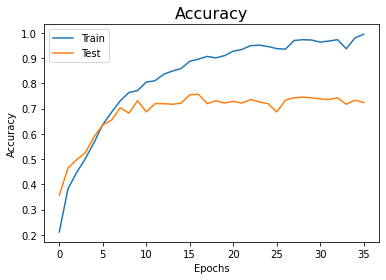

In [ ]:
plt.title('Accuracy', fontsize=16)
plt.plot(model_orig_data_history.history['accuracy'])
plt.plot(model_orig_data_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

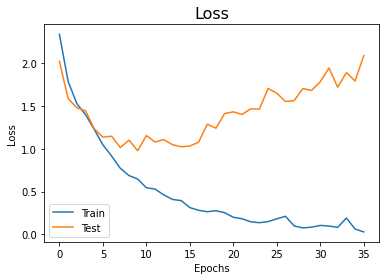

In [ ]:
plt.title('Loss', fontsize=16)
plt.plot(model_orig_data_history.history['loss'])
plt.plot(model_orig_data_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

- Unsurprisingly, we have the same overfitting problem as before. 
- Let's see if we can get better results using the augmented data.

#### Training Model 1 on Augmented Data

In [ ]:
model_aug_data_df, model_aug_data, model_aug_data_history = model_repeater(train_generator, validation_data=val_generator)

15/15 [==============================] - 0s 12ms/step - loss: 0.5704 - accuracy: 0.8000
Model 1 is trained.
15/15 [==============================] - 0s 12ms/step - loss: 0.6928 - accuracy: 0.7663
Model 2 is trained.
15/15 [==============================] - 0s 11ms/step - loss: 0.5331 - accuracy: 0.8358
Model 3 is trained.
15/15 [==============================] - 0s 11ms/step - loss: 0.6203 - accuracy: 0.7853
Model 4 is trained.
15/15 [==============================] - 0s 11ms/step - loss: 0.6756 - accuracy: 0.7789
Model 5 is trained.
15/15 [==============================] - 0s 11ms/step - loss: 0.8034 - accuracy: 0.7242
Model 6 is trained.
15/15 [==============================] - 0s 11ms/step - loss: 0.5914 - accuracy: 0.8295
Model 7 is trained.
15/15 [==============================] - 0s 11ms/step - loss: 0.7510 - accuracy: 0.7789
Model 8 is trained.


In [ ]:
model_aug_data_df

,cnn_model_n,accuracy
0,Model 1,0.800000
1,Model 2,0.766316
2,Model 3,0.835790
3,Model 4,0.785263
4,Model 5,0.778947
5,Model 6,0.724211
6,Model 7,0.829474
7,Model 8,0.778947


In [ ]:
model_aug_data_df['accuracy'].mean()

0.7873684242367744

- Our average accuracy is 8 points higher than the previous group.
- Data augmentation clearly improves model performance.

In [ ]:
model_aug_data.evaluate(X_test, y_test_enc)

15/15 [==============================] - 0s 10ms/step - loss: 0.5331 - accuracy: 0.8358


[0.5331022143363953, 0.8357895016670227]

- Our best model achieved an accuracy of 83.6%.

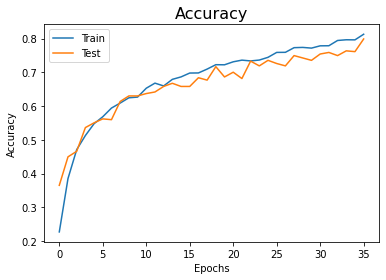

In [ ]:
plt.title('Accuracy', fontsize=16)
plt.plot(model_aug_data_history.history['accuracy'])
plt.plot(model_aug_data_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

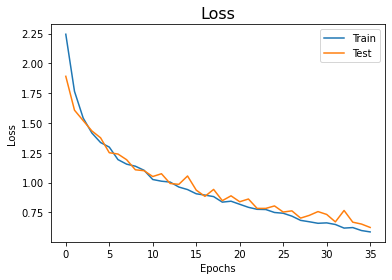

In [ ]:
plt.title('Loss', fontsize=16)
plt.plot(model_aug_data_history.history['loss'])
plt.plot(model_aug_data_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

- The accuracy and loss curves for both training and testing data are much more equal and show almost no signs of overfitting.

#### Plot the Confusion Matrix




In [ ]:
# calculating predictions
y_pred_aug = model_aug_data.predict(X_test)

15/15 [==============================] - 0s 8ms/step


In [ ]:
# retrieving original labels from the LabelBinarizer
y_pred_labels_aug = binarizer.inverse_transform(y_pred_aug)

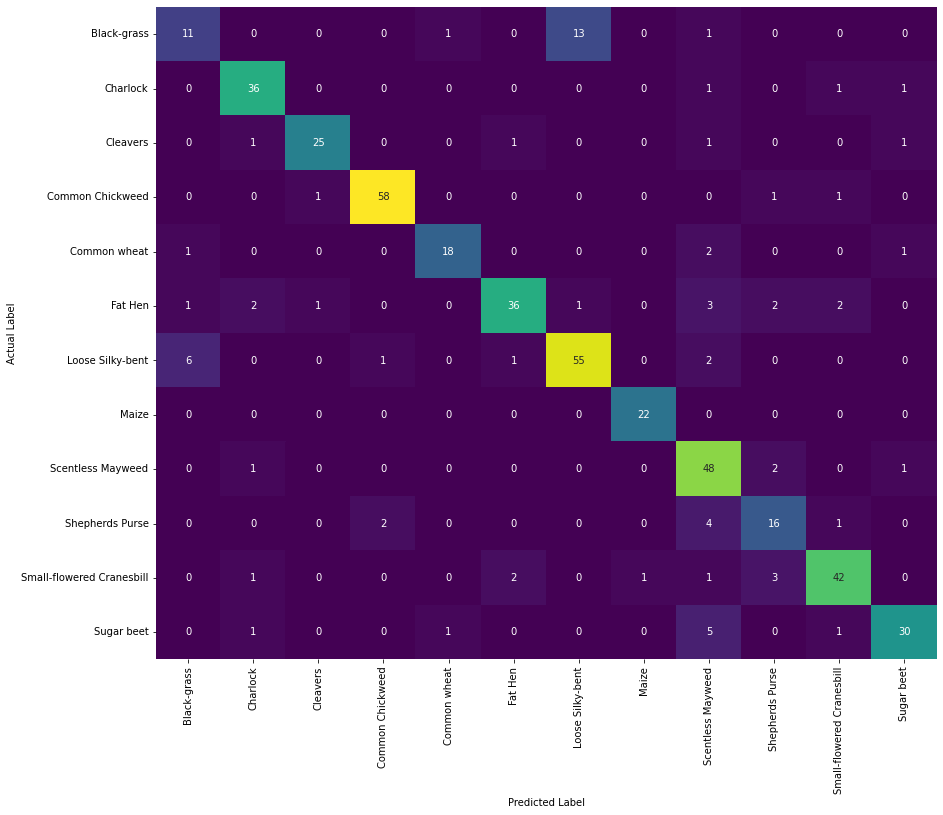

In [ ]:
make_confusion_matrix(y_test_labels, y_pred_labels_aug, labels=labels_alpha)

- The model is still periodically confusing Loose Silky-bent and Black-grass.
  - As we said before, the similar appearances of these plants makes these two species difficult to distinguish.
  - However, if our goal is to eliminate both these seedlings because they are weeds, then this issue is not a factor.
- Sugar beet was also misclassified as Scentless Mayweed 5 times.
- Besides that, **our model has markedly improved after being trained on the augmented data**.

#### Plot Classification Report





In [ ]:
print(classification_report(y_test_labels, y_pred_labels_aug))

                           precision    recall  f1-score   support

              Black-grass       0.58      0.42      0.49        26
                 Charlock       0.86      0.92      0.89        39
                 Cleavers       0.93      0.86      0.89        29
         Common Chickweed       0.95      0.95      0.95        61
             Common wheat       0.90      0.82      0.86        22
                  Fat Hen       0.90      0.75      0.82        48
         Loose Silky-bent       0.80      0.85      0.82        65
                    Maize       0.96      1.00      0.98        22
        Scentless Mayweed       0.71      0.92      0.80        52
          Shepherds Purse       0.67      0.70      0.68        23
Small-flowered Cranesbill       0.88      0.84      0.86        50
               Sugar beet       0.88      0.79      0.83        38

                 accuracy                           0.84       475
                macro avg       0.83      0.82      0.82    

- Common Chickweed and Cleavers remained among across all metrics.
- Charlock, Common wheat, and Maize also had high scores.
  - The model identified every single Maize seedling (recall of 1) and had a precision of 0.96. 
- Precision, recall, and F1-scores are all higher across the board.
- Black-grass is still lagging behind, as we noticed from the confusion matrix.

## Model 2 <a name='model_2'></a>

- Our first model performed well when it was trained on the augmented data. Let's see if we can top that performance by adding more convolutional layers to the model and training it with the augmented data.

In [ ]:
# defining new model repeater function with more convolutional layers
def model_repeater_2(X_train, y_train=None, validation_split=0, validation_data=None):
    results = pd.DataFrame(columns=['cnn_model_n', 'accuracy']) # dataframe to save accuracy scores
    cnn_model_n = 1 # defining a variable to track our progress
    best_accuracy = 0
    best_model = 0
    best_model_history = 0
    while cnn_model_n < 9: # training 8 models
      backend.clear_session()
      # adding two more convolutional layers
      cnn_model = Sequential()
      cnn_model.add(Conv2D(256, (3,3), padding = 'same', activation = 'relu', input_shape = (128,128,3)))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Flatten())
      cnn_model.add(Dense(32, activation = 'relu'))
      cnn_model.add(Dense(16, activation = 'relu'))
      cnn_model.add(Dense(12, activation = 'softmax'))
      # compiling
      cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
      # fitting the model and saving the history
      history = cnn_model.fit(X_train, y_train, batch_size=32, epochs=36, 
                              validation_split=validation_split, validation_data=validation_data, verbose=0)
      accuracy = cnn_model.evaluate(X_test, y_test_enc) # evaluating the model on the test data
      accuracy = accuracy[1]
      results = results.append({'cnn_model_n':f'Model {cnn_model_n}', 'accuracy':accuracy}, ignore_index=True) # adding the results to the dataframe
      print(f'Model {cnn_model_n} is trained.')
      cnn_model_n += 1
      # saving the model if it has the highest accuracy score
      if accuracy > best_accuracy:
        best_model = cnn_model
        best_accuracy = accuracy
        best_model_history = history
      else:
        del cnn_model
    return results, best_model, best_model_history

#### Training Model 2

In [ ]:
model_2_aug_data_df, model_2_aug_data, model_2_aug_data_history = model_repeater_2(train_generator, validation_data=val_generator)

15/15 [==============================] - 1s 71ms/step - loss: 0.4795 - accuracy: 0.8379
Model 1 is trained.
15/15 [==============================] - 0s 32ms/step - loss: 0.5025 - accuracy: 0.8189
Model 2 is trained.
15/15 [==============================] - 0s 31ms/step - loss: 0.4958 - accuracy: 0.8295
Model 3 is trained.
15/15 [==============================] - 0s 32ms/step - loss: 0.3820 - accuracy: 0.8821
Model 4 is trained.
15/15 [==============================] - 0s 31ms/step - loss: 0.5864 - accuracy: 0.8063
Model 5 is trained.
15/15 [==============================] - 0s 31ms/step - loss: 0.4043 - accuracy: 0.8632
Model 6 is trained.
15/15 [==============================] - 0s 32ms/step - loss: 0.5222 - accuracy: 0.8295
Model 7 is trained.
15/15 [==============================] - 0s 31ms/step - loss: 0.6190 - accuracy: 0.7811
Model 8 is trained.


In [ ]:
model_2_aug_data_df

,cnn_model_n,accuracy
0,Model 1,0.837895
1,Model 2,0.818947
2,Model 3,0.829474
3,Model 4,0.882105
4,Model 5,0.806316
5,Model 6,0.863158
6,Model 7,0.829474
7,Model 8,0.781053


In [ ]:
model_2_aug_data_df['accuracy'].mean()

0.8310526311397552

- With the addition of two convolutional layers, our average accuracy score improved by 5 percentage points.

#### Model Evaluation

In [ ]:
model_2_aug_data.evaluate(X_test, y_test_enc)

15/15 [==============================] - 1s 31ms/step - loss: 0.3820 - accuracy: 0.8821


[0.3820289075374603, 0.88210529088974]

- The best model scored **88% accuracy** on the test data.


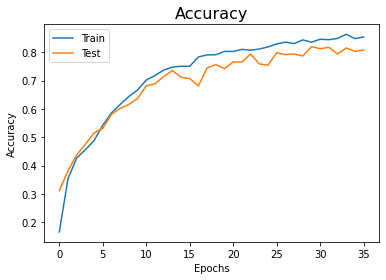

In [ ]:
plt.title('Accuracy', fontsize=16)
plt.plot(model_2_aug_data_history.history['accuracy'])
plt.plot(model_2_aug_data_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

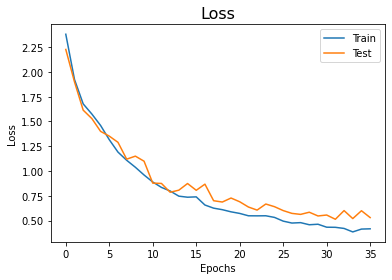

In [ ]:
plt.title('Loss', fontsize=16)
plt.plot(model_2_aug_data_history.history['loss'])
plt.plot(model_2_aug_data_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

- There does appear to be a bit more overfitting than the previous model. This makes sense due to the addition of more convolutional layers.
- The effect is mild though -- nowhere near as egregious as the first model.

#### Plotting the Confusion Matrix

15/15 [==============================] - 0s 29ms/step


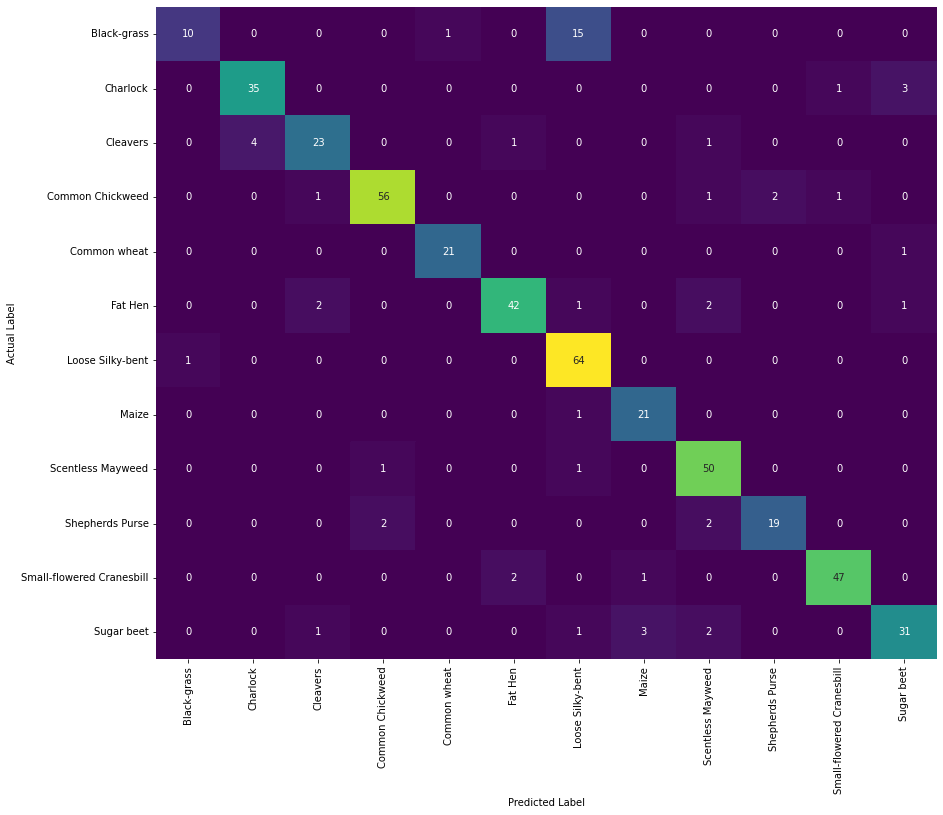

In [ ]:
y_pred_2 = model_2_aug_data.predict(X_test)

y_pred_2_labels = binarizer.inverse_transform(y_pred_2)

make_confusion_matrix(y_test_labels, y_pred_2_labels, labels=labels_alpha)

- The models continue to misclassify Black-grass as Loose Silky-bent. 
  - In this case, 15 Black-grass plants were misclassified as Loose Silky-bent, while only 10 Black-grass seedlings were properly classified. 
- Besides that, our rates of misclassification were low -- especially compared to prior performance.

**Observation:**


#### Plot Classification Report

In [ ]:
print(classification_report(y_test_labels, y_pred_2_labels))

                           precision    recall  f1-score   support

              Black-grass       0.91      0.38      0.54        26
                 Charlock       0.90      0.90      0.90        39
                 Cleavers       0.85      0.79      0.82        29
         Common Chickweed       0.95      0.92      0.93        61
             Common wheat       0.95      0.95      0.95        22
                  Fat Hen       0.93      0.88      0.90        48
         Loose Silky-bent       0.77      0.98      0.86        65
                    Maize       0.84      0.95      0.89        22
        Scentless Mayweed       0.86      0.96      0.91        52
          Shepherds Purse       0.90      0.83      0.86        23
Small-flowered Cranesbill       0.96      0.94      0.95        50
               Sugar beet       0.86      0.82      0.84        38

                 accuracy                           0.88       475
                macro avg       0.89      0.86      0.86    

- Black-grass still has the lowest recall and F1-scores (as we saw above).
- Loose Silky-bent has the lowest precision (which is caused by the same problem that led to the first observation).
- Besides that, precision, recall, and F1-scores remain strong.

## Model 3 <a name='model_3'></a>

- The additional convolutional layers improved the model's performance. There appear to be some overfitting, which we can address with dropout and batch normalization. Let's see what happens when we add batch normalization.

In [ ]:
# defining new model repeater function with batch normalization
def model_repeater_3(X_train, y_train=None, validation_split=0, validation_data=None):
    results = pd.DataFrame(columns=['cnn_model_n', 'accuracy']) # dataframe to save accuracy scores
    cnn_model_n = 1 # defining a variable to track our progress
    best_accuracy = 0
    best_model = 0
    best_model_history = 0
    while cnn_model_n < 9: # training 8 models
      backend.clear_session()
      # adding batch normalization
      cnn_model = Sequential()
      cnn_model.add(Conv2D(256, (3,3), padding = 'same', activation = 'relu', input_shape = (128,128,3)))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Flatten())
      cnn_model.add(Dense(32, activation = 'relu'))
      cnn_model.add(Dense(16, activation = 'relu'))
      cnn_model.add(Dense(12, activation = 'softmax'))
      # compiling
      cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
      # fitting the model and saving the history
      history = cnn_model.fit(X_train, y_train, batch_size=32, epochs=36, 
                              validation_split=validation_split, validation_data=validation_data, verbose=0)
      accuracy = cnn_model.evaluate(X_test, y_test_enc) # evaluating the model on the test data
      accuracy = accuracy[1]
      results = results.append({'cnn_model_n':f'Model {cnn_model_n}', 'accuracy':accuracy}, ignore_index=True) # adding the results to the dataframe
      print(f'Model {cnn_model_n} is trained.')
      cnn_model_n += 1
      # saving the model if it has the highest accuracy score
      if accuracy > best_accuracy:
        best_model = cnn_model
        best_accuracy = accuracy
        best_model_history = history
      else:
        del cnn_model
    return results, best_model, best_model_history

#### Training Model 3

In [ ]:
model_3_aug_data_df, model_3_aug_data, model_3_aug_data_history = model_repeater_3(train_generator, validation_data=val_generator)

15/15 [==============================] - 1s 87ms/step - loss: 2.6647 - accuracy: 0.4295
Model 1 is trained.
15/15 [==============================] - 0s 20ms/step - loss: 0.4613 - accuracy: 0.8716
Model 2 is trained.
15/15 [==============================] - 0s 20ms/step - loss: 0.6815 - accuracy: 0.7853
Model 3 is trained.
15/15 [==============================] - 0s 21ms/step - loss: 1.2124 - accuracy: 0.6632
Model 4 is trained.
15/15 [==============================] - 0s 21ms/step - loss: 0.3423 - accuracy: 0.8737
Model 5 is trained.
15/15 [==============================] - 0s 20ms/step - loss: 0.4666 - accuracy: 0.8463
Model 6 is trained.
15/15 [==============================] - 0s 20ms/step - loss: 1.0025 - accuracy: 0.7558
Model 7 is trained.
15/15 [==============================] - 0s 20ms/step - loss: 1.4370 - accuracy: 0.6253
Model 8 is trained.


In [ ]:
model_3_aug_data_df

,cnn_model_n,accuracy
0,Model 1,0.429474
1,Model 2,0.871579
2,Model 3,0.785263
3,Model 4,0.663158
4,Model 5,0.873684
5,Model 6,0.846316
6,Model 7,0.755789
7,Model 8,0.625263


In [ ]:
model_3_aug_data_df['accuracy'].mean()

0.7313157916069031

- Our average accuracy has decreased below the last two model groups.
- The average is brought down by the first model in the group, which had an abysmal accuracy of 43%.
- Two models had accuracies of 87%, though.
- Our preliminary observations are that Batch Normalization may decrease overfitting, but leads to more performance inconsistency (in this case).

#### Model Evaluation

In [ ]:
model_3_aug_data.evaluate(X_test, y_test_enc)

15/15 [==============================] - 0s 20ms/step - loss: 0.3423 - accuracy: 0.8737


[0.342316210269928, 0.8736842274665833]

- The best model scored 87.4% accuracy.


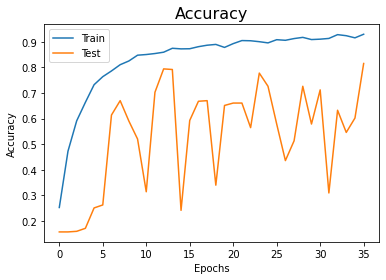

In [ ]:
plt.title('Accuracy', fontsize=16)
plt.plot(model_3_aug_data_history.history['accuracy'])
plt.plot(model_3_aug_data_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

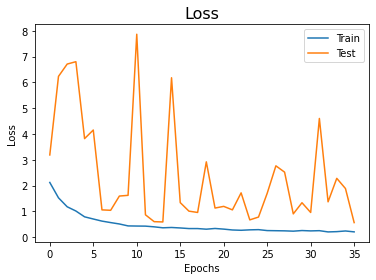

In [ ]:
plt.title('Loss', fontsize=16)
plt.plot(model_3_aug_data_history.history['loss'])
plt.plot(model_3_aug_data_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

- These curves do not look good.
- There is a high amount of noise in the testing curves, and it looks like there may still be overfitting.

#### Plotting the Confusion Matrix

15/15 [==============================] - 0s 18ms/step


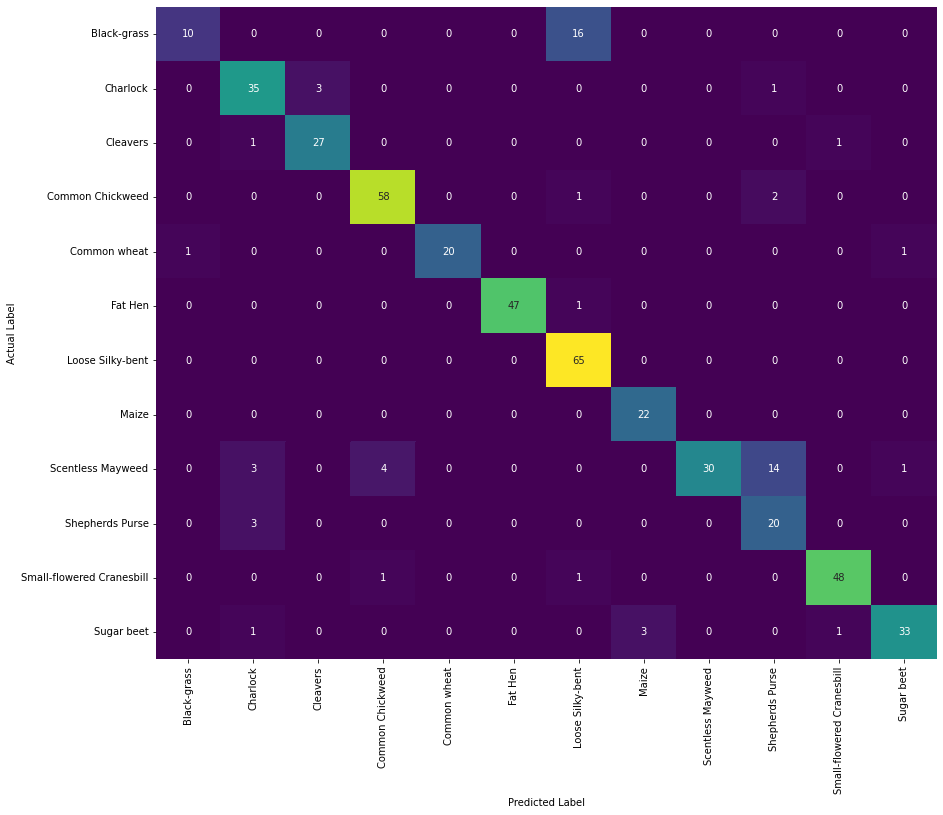

In [ ]:
y_pred_3 = model_3_aug_data.predict(X_test)

y_pred_3_labels = binarizer.inverse_transform(y_pred_3)

make_confusion_matrix(y_test_labels, y_pred_3_labels, labels=labels_alpha)

- Black-grass was still misclassified as Loose-Silky bent 16 times.
- Scentless Mayweed was also misclassified 8 times.
- Sugar beet was classified incorrectly 5 times (3 times as Maize).

**Observation:**


#### Plot Classification Report

In [ ]:
print(classification_report(y_test_labels, y_pred_3_labels))

                           precision    recall  f1-score   support

              Black-grass       0.91      0.38      0.54        26
                 Charlock       0.81      0.90      0.85        39
                 Cleavers       0.90      0.93      0.92        29
         Common Chickweed       0.92      0.95      0.94        61
             Common wheat       1.00      0.91      0.95        22
                  Fat Hen       1.00      0.98      0.99        48
         Loose Silky-bent       0.77      1.00      0.87        65
                    Maize       0.88      1.00      0.94        22
        Scentless Mayweed       1.00      0.58      0.73        52
          Shepherds Purse       0.54      0.87      0.67        23
Small-flowered Cranesbill       0.96      0.96      0.96        50
               Sugar beet       0.94      0.87      0.90        38

                 accuracy                           0.87       475
                macro avg       0.89      0.86      0.85    

- As is tradition, Black-grass has the lowest recall score.
- Loose Silky-bent and Maize had recall scores of 1.
- Common wheat, Fat Hen, and Scentless Mayweed had precision scores of 1.
- Shepherds Purse had the lowest precision at 54%.
- The bottom line is that the addition of Batch Normalization may not have effected the highest accuracy scores, but it made our model's performance much more inconsistent.

## Model 4 <a name='model_4'></a>

Batch Normalization didn't seem to help. Since we had a bump in performance after adding convolutional layers, let's add even more convolutional layers to see what happens. (We will continue using Batch Normalization)

In [ ]:
# defining new model repeater function with more layers
def model_repeater_4(X_train, y_train=None, validation_split=0, validation_data=None):
    results = pd.DataFrame(columns=['cnn_model_n', 'accuracy']) # dataframe to save accuracy scores
    cnn_model_n = 1 # defining a variable to track our progress
    best_accuracy = 0
    best_model = 0
    best_model_history = 0
    while cnn_model_n < 9: # training 8 models
      backend.clear_session()
      # adding more convolutional layers
      cnn_model = Sequential()
      cnn_model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu', input_shape = (128,128,3)))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Conv2D(256, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu'))
      cnn_model.add(MaxPooling2D((2,2), padding = 'same'))
      cnn_model.add(Flatten())
      cnn_model.add(Dense(32, activation = 'relu'))
      # cnn_model.add(Dropout(0.2))
      cnn_model.add(Dense(16, activation = 'relu'))
      cnn_model.add(Dense(12, activation = 'softmax'))
      # compiling
      cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
      # fitting the model and saving the history
      history = cnn_model.fit(X_train, y_train, batch_size=32, epochs=36, 
                              validation_split=validation_split, validation_data=validation_data, verbose=0)
      accuracy = cnn_model.evaluate(X_test, y_test_enc) # evaluating the model on the test data
      accuracy = accuracy[1]
      results = results.append({'cnn_model_n':f'Model {cnn_model_n}', 'accuracy':accuracy}, ignore_index=True) # adding the results to the dataframe
      print(f'Model {cnn_model_n} is trained.')
      cnn_model_n += 1
      # saving the model if it has the highest accuracy score
      if accuracy > best_accuracy:
        best_model = cnn_model
        best_accuracy = accuracy
        best_model_history = history
      else:
        del cnn_model
    return results, best_model, best_model_history

#### Training Model 4

In [ ]:
model_4_aug_data_df, model_4_aug_data, model_4_aug_data_history = model_repeater_4(train_generator, validation_data=val_generator)

15/15 [==============================] - 1s 81ms/step - loss: 0.9181 - accuracy: 0.7179
Model 1 is trained.
15/15 [==============================] - 0s 15ms/step - loss: 0.7424 - accuracy: 0.7811
Model 2 is trained.
15/15 [==============================] - 0s 15ms/step - loss: 0.6370 - accuracy: 0.8147
Model 3 is trained.
15/15 [==============================] - 0s 14ms/step - loss: 0.3894 - accuracy: 0.8505
Model 4 is trained.
15/15 [==============================] - 0s 15ms/step - loss: 0.7111 - accuracy: 0.7937
Model 5 is trained.
15/15 [==============================] - 0s 15ms/step - loss: 0.4334 - accuracy: 0.8505
Model 6 is trained.
15/15 [==============================] - 0s 14ms/step - loss: 1.3123 - accuracy: 0.6442
Model 7 is trained.
15/15 [==============================] - 0s 14ms/step - loss: 0.7294 - accuracy: 0.7579
Model 8 is trained.


In [ ]:
model_4_aug_data_df

,cnn_model_n,accuracy
0,Model 1,0.717895
1,Model 2,0.781053
2,Model 3,0.814737
3,Model 4,0.850526
4,Model 5,0.793684
5,Model 6,0.850526
6,Model 7,0.644211
7,Model 8,0.757895


In [ ]:
model_4_aug_data_df['accuracy'].mean()

0.7763157933950424

- Average accuracy is around 77.6%. 
- This is still below our best of 83%.

#### Model Evaluation

In [ ]:
model_4_aug_data.evaluate(X_test, y_test_enc)

15/15 [==============================] - 0s 14ms/step - loss: 0.3894 - accuracy: 0.8505


[0.3894162178039551, 0.8505263328552246]

- The best model has an accuracy score of 85%.


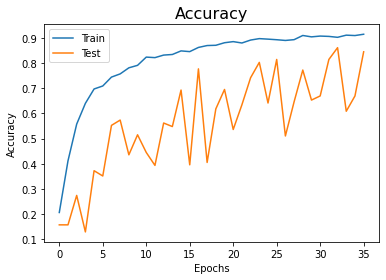

In [ ]:
plt.title('Accuracy', fontsize=16)
plt.plot(model_4_aug_data_history.history['accuracy'])
plt.plot(model_4_aug_data_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

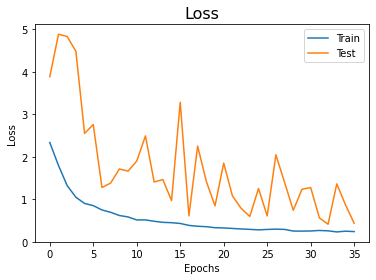

In [ ]:
plt.title('Loss', fontsize=16)
plt.plot(model_4_aug_data_history.history['loss'])
plt.plot(model_4_aug_data_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

- These curves look like the previous model group's.
- We kept Batch Normalization in the model. Because these curves look the same as the last ones despite our adding convolutional layers, we may conclude that Batch Normalization is not helping us.

#### Plotting the Confusion Matrix

15/15 [==============================] - 0s 12ms/step


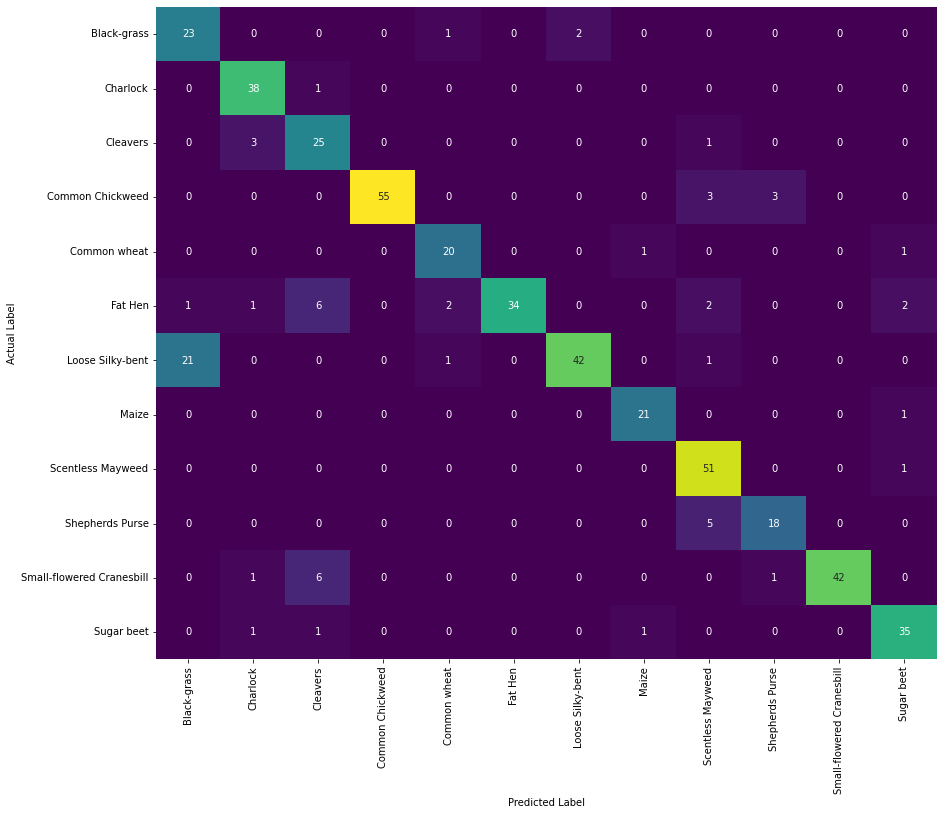

In [ ]:
y_pred_4 = model_4_aug_data.predict(X_test)

y_pred_4_labels = binarizer.inverse_transform(y_pred_4)

make_confusion_matrix(y_test_labels, y_pred_4_labels, labels=labels_alpha)

- This time Loose-Silky bent was misclassified as Black-grass **21 times**.
- The model also misclassifed 12 plants as Cleavers.
- Common Chickweed was classified incorrectly 6 times.
- These results aren't the best we've seen.

#### Plot Classification Report

In [ ]:
print(classification_report(y_test_labels, y_pred_4_labels))

                           precision    recall  f1-score   support

              Black-grass       0.51      0.88      0.65        26
                 Charlock       0.86      0.97      0.92        39
                 Cleavers       0.64      0.86      0.74        29
         Common Chickweed       1.00      0.90      0.95        61
             Common wheat       0.83      0.91      0.87        22
                  Fat Hen       1.00      0.71      0.83        48
         Loose Silky-bent       0.95      0.65      0.77        65
                    Maize       0.91      0.95      0.93        22
        Scentless Mayweed       0.81      0.98      0.89        52
          Shepherds Purse       0.82      0.78      0.80        23
Small-flowered Cranesbill       1.00      0.84      0.91        50
               Sugar beet       0.88      0.92      0.90        38

                 accuracy                           0.85       475
                macro avg       0.85      0.86      0.85    

- Small-flowered Cranesbill, Fat Hen, and Common Chickweed had precision scores of 1.
- Black-grass had the lowest precision score of 0.51.
- While many metrics remain high, some slipped below average (Black-grass, Cleavers, Shepherds Purse).
- We may conclude that Batch Normalization may not be the way to handle overfitting for our purposes (or that we are using too many instances of Batch Normalization).

## Model 5 <a name='model_5'></a>

For our last model, let's see if transfer learning can help us. Because the differences in plant species are often minute, I speculate that a model trained on the Imagenet dataset may not easily pick up on these nuances. Let's find out.

#### Clearing the backend session and initializing the random seed values

In [ ]:
# clearing the backend session
backend.clear_session()

In [ ]:
# initializing random seed values
import random
np.random.seed(1)
random.seed(1) 
tf.random.set_seed(1)

In [ ]:
# loading VGG16
vgg_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (128, 128, 3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
# freezing the layers
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
# initializing the model
model_5_vgg = Sequential()

# adding VGG16 (without fully connected layers)
model_5_vgg.add(vgg_model)

# adding our own fully connected layers
model_5_vgg.add(Flatten())
model_5_vgg.add(Dense(32, activation = 'relu'))
model_5_vgg.add(Dense(16, activation = 'relu'))
model_5_vgg.add(Dense(12, activation = 'softmax'))

In [ ]:
# compiling the model
model_5_vgg.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model_5_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 14,977,596
Trainable params: 262,908
Non-trainable params: 14,714,688
_________________________________________________________________


#### Fitting the model on the train data

In [ ]:
history_5 = model_5_vgg.fit(train_generator, validation_data = val_generator, batch_size = 32, epochs = 36)

Epoch 1/36
121/121 [==============================] - 17s 134ms/step - loss: 2.2867 - accuracy: 0.2349 - val_loss: 2.0811 - val_accuracy: 0.2763
Epoch 2/36
121/121 [==============================] - 14s 114ms/step - loss: 1.9889 - accuracy: 0.3272 - val_loss: 1.8429 - val_accuracy: 0.4028
Epoch 3/36
121/121 [==============================] - 14s 116ms/step - loss: 1.6627 - accuracy: 0.4345 - val_loss: 1.4927 - val_accuracy: 0.4824
Epoch 4/36
121/121 [==============================] - 15s 123ms/step - loss: 1.4251 - accuracy: 0.5143 - val_loss: 1.3528 - val_accuracy: 0.5199
Epoch 5/36
121/121 [==============================] - 15s 125ms/step - loss: 1.2567 - accuracy: 0.5754 - val_loss: 1.1297 - val_accuracy: 0.6323
Epoch 6/36
121/121 [==============================] - 15s 125ms/step - loss: 1.1744 - accuracy: 0.5993 - val_loss: 1.1142 - val_accuracy: 0.5948
Epoch 7/36
121/121 [==============================] - 15s 120ms/step - loss: 1.1046 - accuracy: 0.6221 - val_loss: 1.0621 - val_ac

#### Model Evaluation

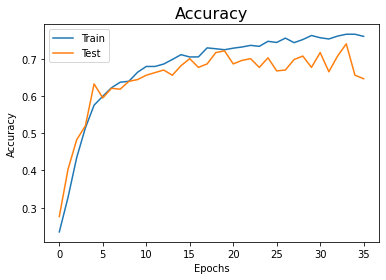

In [ ]:
plt.title('Accuracy', fontsize=16)
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

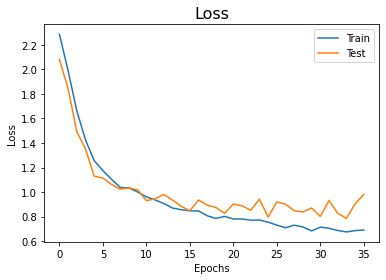

In [ ]:
plt.title('Loss', fontsize=16)
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

- There appears to be a small amount of overfitting.

#### Evaluating the model on test data

In [ ]:
model_5_vgg.evaluate(X_test, y_test_enc)

15/15 [==============================] - 2s 148ms/step - loss: 0.9055 - accuracy: 0.6905


[0.9055373072624207, 0.6905263066291809]

- The VGG based model scored 69% accuracy on the testing data.

#### Plotting the Confusion Matrix

15/15 [==============================] - 1s 57ms/step


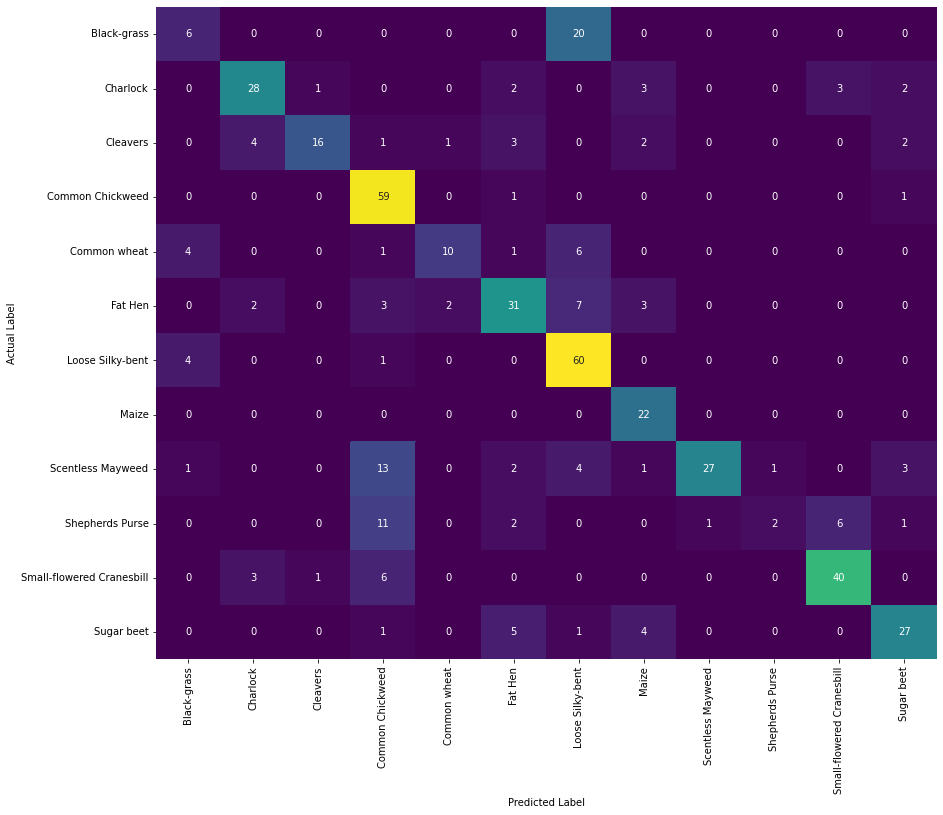

In [ ]:
y_pred_5 = model_5_vgg.predict(X_test)

y_pred_5_labels = binarizer.inverse_transform(y_pred_5)

make_confusion_matrix(y_test_labels, y_pred_5_labels, labels=labels_alpha)

- There were many more misclassifications here than we've seen previously.
- 37 seedlings were incorrectly identified as Common Chickweed.
- 16 seedlings were incorrectly identified as Fat Hen.
- 12 seedlings were incorrectly identified as Maize.
- Overall, these results are not very good.

**Observation:**


#### Plot Classification Report

In [ ]:
print(classification_report(y_test_labels, y_pred_5_labels))

                           precision    recall  f1-score   support

              Black-grass       0.40      0.23      0.29        26
                 Charlock       0.76      0.72      0.74        39
                 Cleavers       0.89      0.55      0.68        29
         Common Chickweed       0.61      0.97      0.75        61
             Common wheat       0.77      0.45      0.57        22
                  Fat Hen       0.66      0.65      0.65        48
         Loose Silky-bent       0.61      0.92      0.74        65
                    Maize       0.63      1.00      0.77        22
        Scentless Mayweed       0.96      0.52      0.67        52
          Shepherds Purse       0.67      0.09      0.15        23
Small-flowered Cranesbill       0.82      0.80      0.81        50
               Sugar beet       0.75      0.71      0.73        38

                 accuracy                           0.69       475
                macro avg       0.71      0.63      0.63    

- Recall for Shepherds Purse was only 0.09.
- Black-grass recall was only 0.23.
- Maize recall was 1.
- The takeway here may be that our task isn't similar enough to the original VGG's task, so the trained architecture we borrowed won't be effective.

## Final Model Comparison <a name='model_comp'></a>

In [ ]:
# creating dataframe to compare best models
best_model_comparison = pd.DataFrame(columns=['Model', 'Accuracy'])

# calculating model accuracies
accuracy_1 = model_aug_data.evaluate(X_test, y_test_enc)[1]
accuracy_2 = model_2_aug_data.evaluate(X_test, y_test_enc)[1]
accuracy_3 = model_3_aug_data.evaluate(X_test, y_test_enc)[1]
accuracy_4 = model_4_aug_data.evaluate(X_test, y_test_enc)[1]
accuracy_5 = model_5_vgg.evaluate(X_test, y_test_enc)[1]

In [ ]:
# adding accuracies to dataframe
best_model_comparison = best_model_comparison.append({'Model':'Model 1', 'Accuracy':accuracy_1}, ignore_index=True)
best_model_comparison = best_model_comparison.append({'Model':'Model 2', 'Accuracy':accuracy_2}, ignore_index=True)
best_model_comparison = best_model_comparison.append({'Model':'Model 3', 'Accuracy':accuracy_3}, ignore_index=True)
best_model_comparison = best_model_comparison.append({'Model':'Model 4', 'Accuracy':accuracy_4}, ignore_index=True)
best_model_comparison = best_model_comparison.append({'Model':'Model 5', 'Accuracy':accuracy_5}, ignore_index=True)

best_model_comparison

,Model,Accuracy
0,Model 1,0.835790
1,Model 2,0.882105
2,Model 3,0.873684
3,Model 4,0.850526
4,Model 5,0.690526


- The best model was **Model 2** with 5 convolutional layers trained on the augmented data. It scored 88.2% accuracy on the test set.
- The remaining best models performed well except for the VGG model, which scored below 70%.

### Visualizing Model 2 Predictions

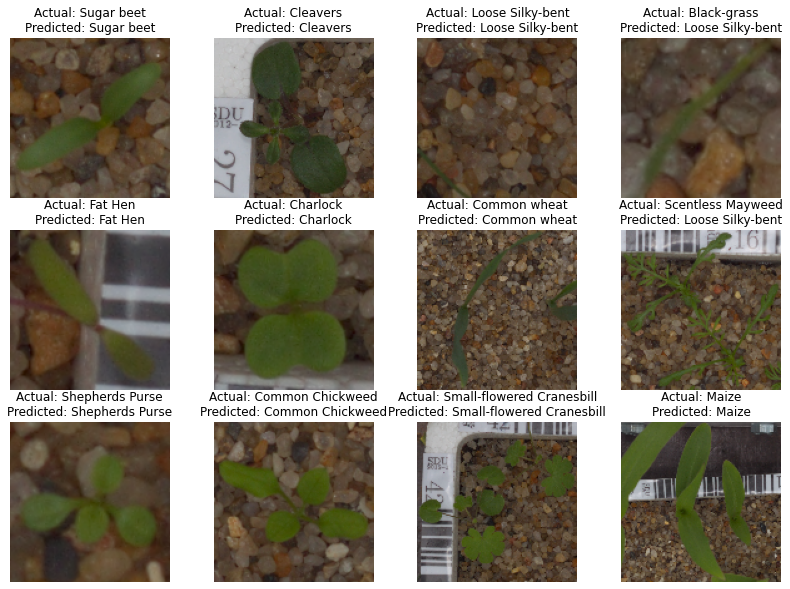

In [ ]:
# plotting a random assortment of each plant species
counter = 0
plotted = []
indexes = []
plt.figure(figsize = (14,10))


# plotting 12 random predictions from Model 2
while counter < 12:
  index = np.random.randint(0, len(y_test_labels))
  label = y_test_labels[index]
  pred_label = y_pred_2_labels[index]
  if label not in plotted:
    plt.subplot(3, 4, counter + 1)
    plt.imshow(X_test[index])
    plt.title(f'Actual: {label}\nPredicted: {pred_label}')
    plt.axis('off')
    plotted.append(label)
    indexes.append(index)
    counter += 1
  else:
    pass

plt.show()

- We can see that in this random assortment of 12 predictions, Model 2 correctly identified all but 2 plants.
  - One was Black-grass, which we've identified as a problem area.
    - The thin appearance of these leaves resemble that of Loose Silky-bent -- to the point that they're nearly indistinguishable to the human eye.
  - The other misclassification was another thin-leaved plant that the model misclassified as Loose Silky-bent.

In [ ]:
# saving the final model to a separate variable
final_model = model_2_aug_data

## Conclusion <a name='conclusion'></a>

- We trained several models:
  - First, we trained a basic CNN on our regular training data.
  - Then we used the same CNN but instead trained on augmented data.
    - We saw a big improvement with this method.
  - From there, we added more convolutional layers and still saw a bump in performance.
  - Then we tried adding Batch Normalization to control overfitting, but this only made model performance more inconsistent.
  - We even tried adding more convolutional layers to compensate, but this didn't work either.
  - Lastly, we tried to use VGG16 to classify the seedlings, but our first attempt did not perform better than our previous bests.

- The best model was **Model 2**, which is composed of 5 convolutional layers, each with a Max Pooling layer, and 3 fully connected layers.
  - **I recommend that this model be utilized for further testing and development to accurately classify seedlings**.

- The models frequently confused Black-grass and Loose Silky-bent due to their similar appearance. 
  - Perhaps we can acquire more images of these plants to further train the models to pick up on differences between the two species.

**Ideas for Improvement**:
- Obtain more images to train models.
- Try other image preprocessing techniques on training data.
- Try other CNN architectures.
- Try using dropout and/or fewer instances of batch normalization.
- Try hyperparameter tuning.
- Add callbacks.
- Use several CNNs in ensemble to make predictions.
- Try other transfer learning models.
